# Functional RMI in Nutshell

https://arxiv.org/pdf/1304.3880.pdf
    

- Representation of brain connectivity is often called the functional connectome
- "Functional connectivity" is defined as a measure of synchronization in brain signals
- By "functional connectome", here we specifically denote a graph representing functional interactions in the brain

### How to exstimate functional connectome

- Confounding signal : (wiki) variable that influences both the dependent variable and independent variable causing a spurious association

- RoI and atlases

- For  the  problem  of  recovering  the  functional connectivity structure, i.e. finding which region is connected to which, **sparse inverse covariance estimators** have been found to be efficient

- Inverse-covariance matrix, which captures partial correlations, appears then as extracting a backbone or core of the graph




In [1]:
path = ".."

import os
import sys
sys.path.insert(0, path)

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [2]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)

In [3]:
fmri_cols = [c for c in data_train_.columns if "fmri" in c]
fmri_cols

['fmri_basc064',
 'fmri_basc122',
 'fmri_basc197',
 'fmri_craddock_scorr_mean',
 'fmri_harvard_oxford_cort_prob_2mm',
 'fmri_motions',
 'fmri_msdl',
 'fmri_power_2011',
 'fmri_select']

In [4]:
accepted_fmri = data_train_['fmri_select'] > 0

In [5]:
def _load_fmri(fmri_filenames):
    """Load time-series extracted from the fMRI using a specific atlas."""
    return np.array([pd.read_csv(subject_filename,
                                 header=None).values
                     for subject_filename in fmri_filenames])


In [25]:
idx = data_train_.index[0]

In [26]:
path_motions = os.path.join(path, data_train_.loc[idx, 'fmri_motions'])
confounds = np.loadtxt(path_motions)

In [40]:
path_fmri_msdl = os.path.join(path, data_train_.loc[idx, 'fmri_msdl'])

from nilearn import datasets
atlas = datasets.fetch_atlas_msdl()
# Loading atlas data stored in 'labels'
labels = atlas['labels']


Dataset created in /root/nilearn_data/msdl_atlas



Downloaded 209734 of 209734 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)
Extracting data from /root/nilearn_data/msdl_atlas/5d25e157f36214b8ca9a12fd417aac1c/MSDL_rois.zip..... done.
/opt/conda/envs/rampwf/lib/python3.6/site-packages/numpy/lib/npyio.py:2266: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [28]:
import numpy as np
import pandas as pd
from nilearn.signal import clean

confounds = np.loadtxt(path_motions)
timeseries = pd.read_csv(path_fmri_msdl, header=None).values
cleaned_timeseries = clean(timeseries, confounds=confounds)

In [31]:
cleaned_timeseries.shape, timeseries.shape

((156, 39), (156, 39))

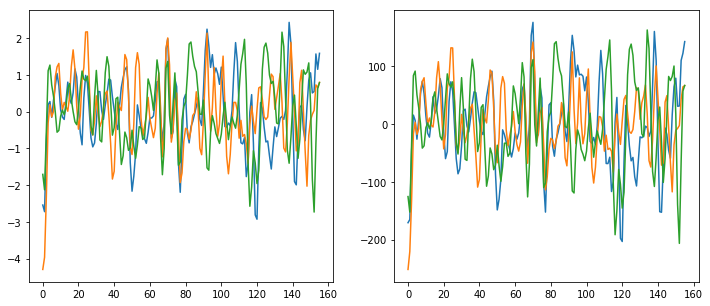

In [38]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(cleaned_timeseries[:, :3])
plt.subplot(122)
plt.plot(timeseries[:, :3])

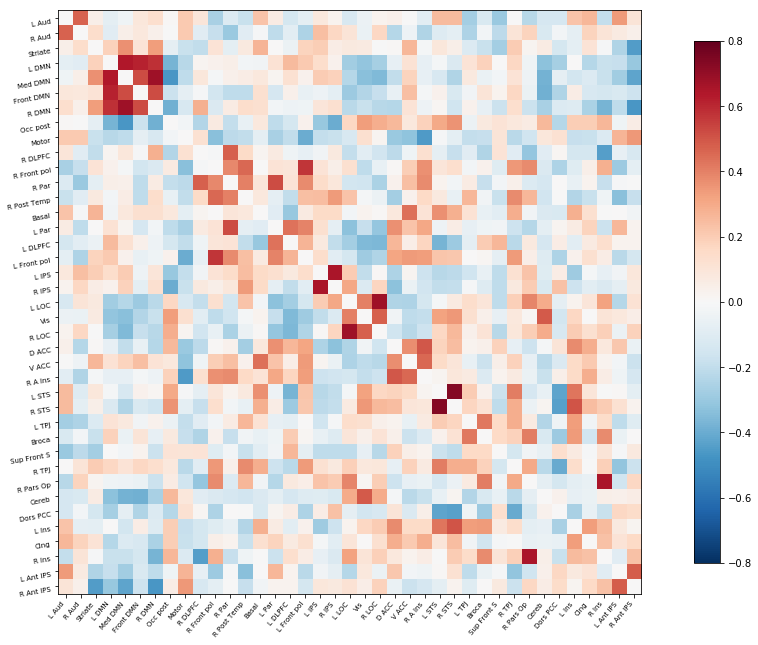

In [44]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([cleaned_timeseries])[0]


# Display the correlation matrix
import numpy as np
from nilearn import plotting
# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
fig = plt.figure(figsize=(12, 12))
plotting.plot_matrix(correlation_matrix, labels=labels, colorbar=True, figure=fig,
                     vmax=0.8, vmin=-0.8)


In [47]:
ConnectivityMeasure??

In [50]:
correlation_matrix.shape

(39, 39)

In [46]:
coords

[(-53.28, -8.88, 32.36),
 (53.47, -6.49, 27.52),
 (1.18, -74.54, 10.79),
 (-45.8, -64.78, 31.84),
 (-0.2, -55.21, 29.87),
 (-0.15, 51.42, 7.58),
 (51.66, -59.34, 28.88),
 (0.41, -91.05, 1.58),
 (-1.48, -27.93, 61.5),
 (40.1, 20.96, 44.72),
 (37.83, 55.49, 1.22),
 (47.53, -52.42, 43.06),
 (62.53, -32.99, -9.14),
 (-0.91, -2.75, 6.15),
 (-41.66, -59.04, 44.61),
 (-39.04, 19.28, 43.27),
 (-40.08, 50.65, 0.81),
 (-29.39, -59.43, 44.2),
 (31.6, -58.09, 45.69),
 (-30.54, -85.14, 9.1),
 (-24.29, -74.28, -11.74),
 (33.4, -77.96, 4.31),
 (-28.17, 46.32, 21.56),
 (-0.45, 34.06, 20.73),
 (28.38, 47.72, 22.13),
 (-52.12, -17.92, 13.28),
 (52.61, -13.65, 12.11),
 (-55.52, -43.77, 10.08),
 (-48.66, 25.11, 5.7),
 (-3.39, 17.19, 63.52),
 (54.42, -29.5, -2.72),
 (52.38, 29.39, 2.93),
 (1.05, -58.49, -23.91),
 (-1.44, -59.12, 55.25),
 (-41.33, 13.63, 2.7),
 (1.05, 9.2, 46.43),
 (43.01, 14.3, 2.79),
 (-47.85, -32.07, 41.9),
 (48.36, -29.04, 43.13)]

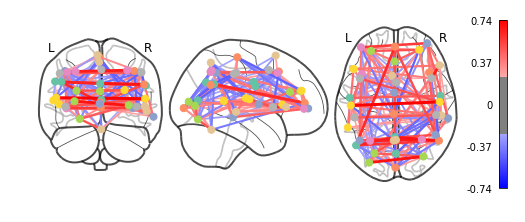

In [45]:
from nilearn import plotting
coords = atlas.region_coords

# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()



In [88]:
idx = data_train_.index[1]

path_motions = os.path.join(path, data_train_.loc[idx, 'fmri_motions'])
confounds = np.loadtxt(path_motions)
path_fmri_msdl = os.path.join(path, data_train_.loc[idx, 'fmri_msdl'])
timeseries = pd.read_csv(path_fmri_msdl, header=None).values
cleaned_timeseries = clean(timeseries, confounds=confounds)

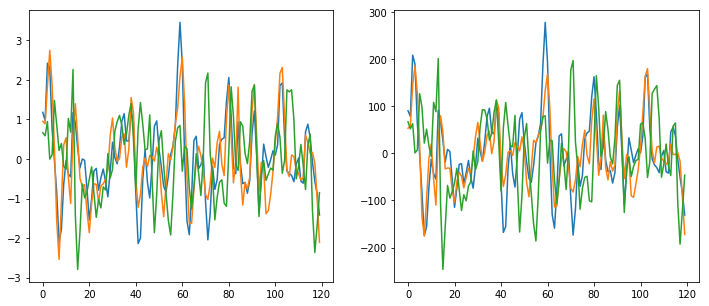

In [89]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(cleaned_timeseries[:, :3])
plt.subplot(122)
plt.plot(timeseries[:, :3])

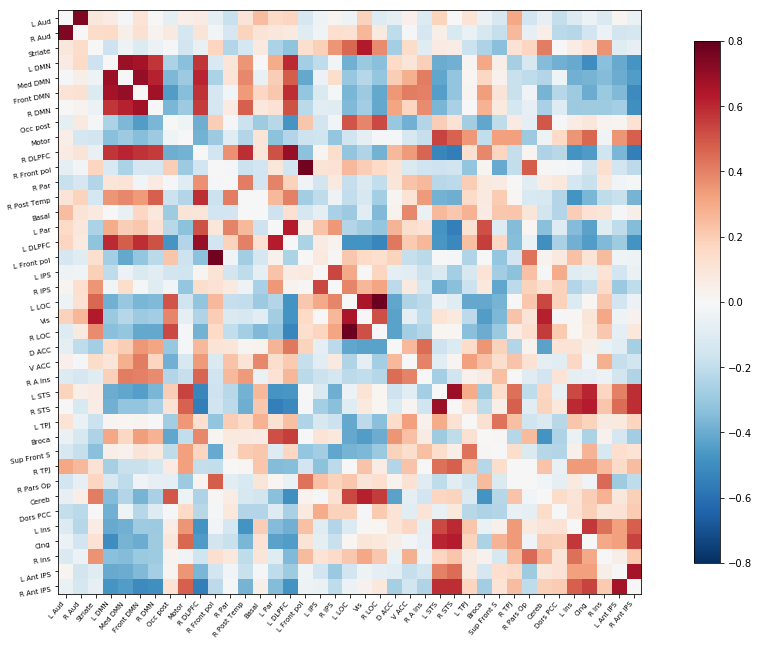

In [90]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([cleaned_timeseries])[0]


# Display the correlation matrix
import numpy as np
from nilearn import plotting
# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
fig = plt.figure(figsize=(12, 12))
plotting.plot_matrix(correlation_matrix, labels=labels, colorbar=True, figure=fig,
                     vmax=0.8, vmin=-0.8)


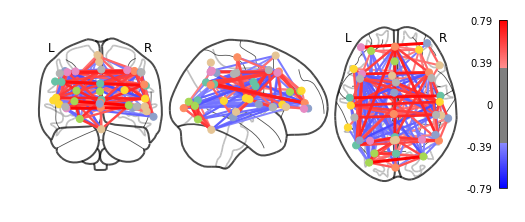

In [91]:
from nilearn import plotting
coords = atlas.region_coords

# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()



### Atlas Power 2011

In [6]:
from nilearn import datasets
atlas = datasets.fetch_coords_power_2011()

In [98]:
idx = data_train_.index[1]

path_motions = os.path.join(path, data_train_.loc[idx, 'fmri_motions'])
confounds = np.loadtxt(path_motions)
path_fmri_power = os.path.join(path, data_train_.loc[idx, 'fmri_power_2011'])
timeseries = pd.read_csv(path_fmri_power, header=None).values
cleaned_timeseries = clean(timeseries, confounds=confounds)

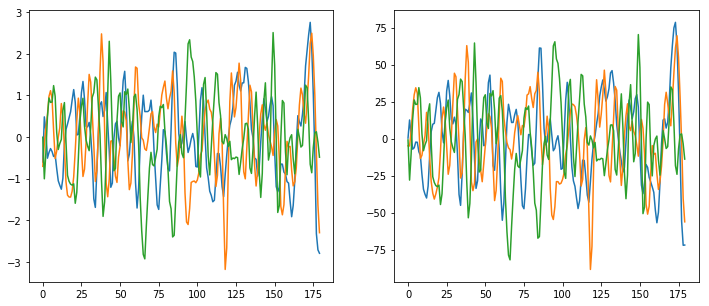

In [116]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(cleaned_timeseries[:, :3])
plt.subplot(122)
plt.plot(timeseries[:, :3])

In [117]:
cleaned_timeseries.shape

(180, 264)

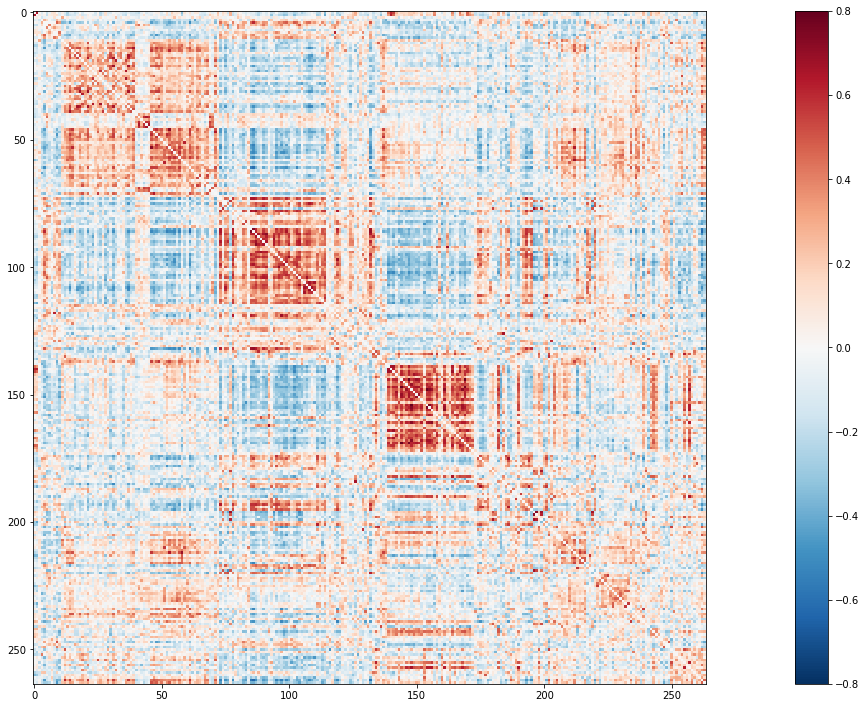

In [100]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([cleaned_timeseries])[0]


# Display the correlation matrix
import numpy as np
from nilearn import plotting
# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
fig = plt.figure(figsize=(12, 12))
plotting.plot_matrix(correlation_matrix, labels=None, colorbar=True, figure=fig,
                     vmax=0.8, vmin=-0.8)


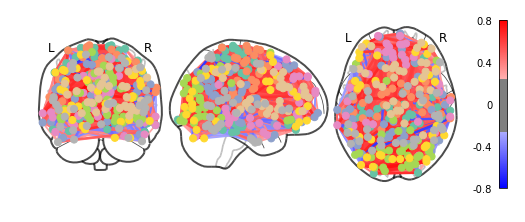

In [106]:
from nilearn import plotting
coords = np.vstack((atlas.rois['x'], atlas.rois['y'], atlas.rois['z'])).T

# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()



## Compare mean correlation matrices

In [107]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)


data_train = pd.concat([data_train_, pd.Series(labels_train_, index=data_train_.index, name='target')], axis=1)

accepted_fmri = data_train['fmri_select'] > 0

In [108]:
data1_train = data_train.loc[accepted_fmri, :]
is_asd = data1_train['target'] > 0

In [109]:
from nilearn.signal import clean
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='covariance', discard_diagonal=True)

In [111]:
mean_no_asd_correlation_matrix = np.zeros((264, 264))

ll = len(data1_train[~is_asd].index)
for i, idx in enumerate(data1_train[~is_asd].index):
    if i % 100 == 0:
        print("-- {}/{}".format(i, ll))
    path_motions = os.path.join(path, data1_train.loc[idx, 'fmri_motions'])
    confounds = np.loadtxt(path_motions)
    path_fmri_atlas = os.path.join(path, data1_train.loc[idx, 'fmri_power_2011'])
    timeseries = pd.read_csv(path_fmri_atlas, header=None).values
    cleaned_timeseries = clean(timeseries, confounds=confounds)
    correlation_matrix = correlation_measure.fit_transform([cleaned_timeseries])[0]
    mean_no_asd_correlation_matrix += correlation_matrix

mean_no_asd_correlation_matrix /= ll

-- 0/533
-- 100/533
-- 200/533
-- 300/533
-- 400/533
-- 500/533


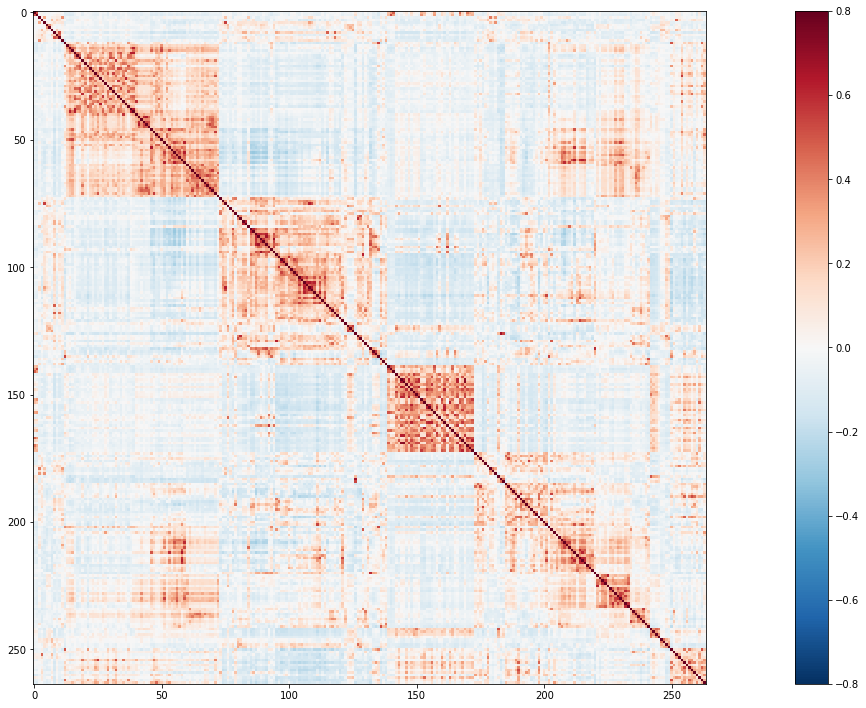

In [113]:
fig = plt.figure(figsize=(12, 12))
plotting.plot_matrix(mean_no_asd_correlation_matrix, labels=None, colorbar=True, figure=fig,
                     vmax=0.8, vmin=-0.8)


In [114]:
mean_asd_correlation_matrix = np.zeros((264, 264))

ll = len(data1_train[is_asd].index)
for i, idx in enumerate(data1_train[is_asd].index):
    if i % 100 == 0:
        print("-- {}/{}".format(i, ll))
    path_motions = os.path.join(path, data1_train.loc[idx, 'fmri_motions'])
    confounds = np.loadtxt(path_motions)
    path_fmri_atlas = os.path.join(path, data1_train.loc[idx, 'fmri_power_2011'])
    timeseries = pd.read_csv(path_fmri_atlas, header=None).values
    cleaned_timeseries = clean(timeseries, confounds=confounds)
    correlation_matrix = correlation_measure.fit_transform([cleaned_timeseries])[0]
    mean_asd_correlation_matrix += correlation_matrix

mean_asd_correlation_matrix /= ll

-- 0/474
-- 100/474
-- 200/474
-- 300/474
-- 400/474


Difference

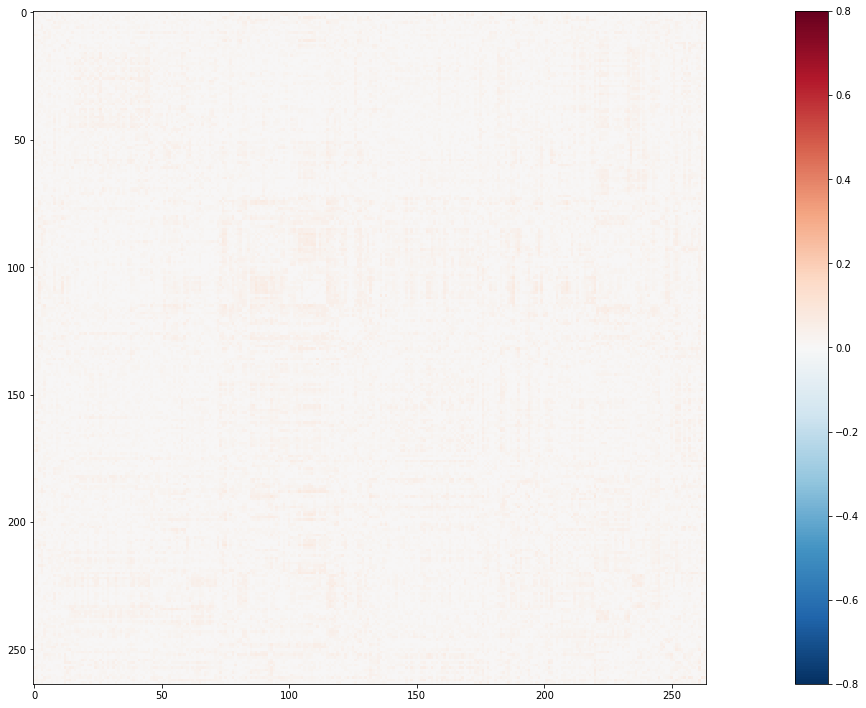

In [115]:
fig = plt.figure(figsize=(12, 12))
plotting.plot_matrix(np.abs(mean_asd_correlation_matrix - mean_no_asd_correlation_matrix), labels=None, colorbar=True, figure=fig,
                     vmax=0.8, vmin=-0.8)


### Altas Power 2011 time series to 3D ROI sequences

In [8]:
from nilearn import datasets
atlas = datasets.fetch_coords_power_2011()

In [15]:
rois = atlas.rois
rois

rec.array([(  1, -25, -98, -12), (  2,  27, -97, -13),
           (  3,  24,  32, -18), (  4, -56, -45, -24),
           (  5,   8,  41, -24), (  6, -21, -22, -20),
           (  7,  17, -28, -17), (  8, -37, -29, -26),
           (  9,  65, -24, -19), ( 10,  52, -34, -27),
           ( 11,  55, -31, -17), ( 12,  34,  38, -12),
           ( 13,  -7, -52,  61), ( 14, -14, -18,  40),
           ( 15,   0, -15,  47), ( 16,  10,  -2,  45),
           ( 17,  -7, -21,  65), ( 18,  -7, -33,  72),
           ( 19,  13, -33,  75), ( 20, -54, -23,  43),
           ( 21,  29, -17,  71), ( 22,  10, -46,  73),
           ( 23, -23, -30,  72), ( 24, -40, -19,  54),
           ( 25,  29, -39,  59), ( 26,  50, -20,  42),
           ( 27, -38, -27,  69), ( 28,  20, -29,  60),
           ( 29,  44,  -8,  57), ( 30, -29, -43,  61),
           ( 31,  10, -17,  74), ( 32,  22, -42,  69),
           ( 33, -45, -32,  47), ( 34, -21, -31,  61),
           ( 35, -13, -17,  75), ( 36,  42, -20,  55),
          

In [ ]:
x_roi_to_index = dict([(v, i) for i, v in enumerate(np.sort(np.unique(rois.x)))])
y_roi_to_index = dict([(v, i) for i, v in enumerate(np.sort(np.unique(rois.y)))])
z_roi_to_index = dict([(v, i) for i, v in enumerate(np.sort(np.unique(rois.z)))])


def timepoint_to_3d(timepoint):
    pass

In [41]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)


data_train = pd.concat([data_train_, pd.Series(labels_train_, index=data_train_.index, name='target')], axis=1)

accepted_fmri = data_train['fmri_select'] > 0

data1_train = data_train.loc[accepted_fmri, :]
is_asd = data1_train['target'] > 0

In [45]:
from nilearn.signal import clean

idx = data1_train.index[0]
path_motions = os.path.join(path, data1_train.loc[idx, 'fmri_motions'])
confounds = np.loadtxt(path_motions)
path_fmri_atlas = os.path.join(path, data1_train.loc[idx, 'fmri_power_2011'])
timeseries = pd.read_csv(path_fmri_atlas, header=None).values
cleaned_timeseries = clean(timeseries, confounds=confounds)

In [46]:
cleaned_timeseries.shape

(156, 264)

In [47]:
tp = cleaned_timeseries[0, :]
tp

array([-0.07208826, -0.07448833, -1.43472607, -1.21638506, -0.41387683,
       -1.44721506,  0.48210593, -0.39931507,  1.24859553,  0.6209452 ,
        0.10124202,  0.28594195, -1.13504805,  0.97638581, -0.32160659,
        0.8698695 , -0.6543776 ,  1.47630467,  1.74410941, -0.75699183,
        0.43471084,  0.51227148,  0.25308197, -0.71524554, -1.40919193,
       -0.74821637, -0.01666575, -0.16041865, -0.24090274,  0.31665274,
        0.77343844,  1.0099083 , -0.2945679 , -1.03966323, -0.20017876,
       -0.17942818, -0.1276754 ,  0.79517488,  0.69504353,  0.63336463,
       -0.62853574, -2.55007951,  1.6743652 , -3.96322482, -1.51136748,
       -3.43410091, -0.35304261, -0.13319313, -0.06544266,  0.288692  ,
       -0.81268577,  1.69350214, -0.04835478,  0.23319962,  0.83804408,
        2.78720679, -0.33008801,  2.18194717, -1.20916565,  2.04813658,
        0.6126044 ,  1.49564639,  0.14450007,  1.6202008 ,  0.54429335,
       -0.10895653,  0.05130069,  2.59540009,  0.54635323,  0.69

In [50]:
len(x_roi_to_index)

106

In [64]:
output = np.zeros((len(x_roi_to_index), len(y_roi_to_index), len(z_roi_to_index)))

for i, v in enumerate(tp):
    ix = x_roi_to_index[rois[i].x]
    iy = y_roi_to_index[rois[i].y]
    iz = z_roi_to_index[rois[i].z]
    print(ix, iy, iz, rois[i], v)
    output[ix, iy, iz] = v

31 0 20 (1, -25, -98, -12) -0.07208826016573361
76 1 19 (2, 27, -97, -13) -0.07448832616032279
73 108 14 (3, 24, 32, -18) -1.4347260735165432
3 40 9 (4, -56, -45, -24) -1.216385060732132
60 114 9 (5, 8, 41, -24) -0.4138768349963167
35 61 12 (6, -21, -22, -20) -1.4472150585781396
67 55 15 (7, 17, -28, -17) 0.48210592691356746
20 54 7 (8, -37, -29, -26) -0.39931506765265073
104 59 13 (9, 65, -24, -19) 1.248595526584277
97 49 6 (10, 52, -34, -27) 0.6209451997197627
100 52 15 (11, 55, -31, -17) 0.10124202162324636
82 112 20 (12, 34, 38, -12) 0.28594195004827166
47 33 89 (13, -7, -52, 61) -1.135048054407375
41 65 69 (14, -14, -18, 40) 0.9763858099710053
52 68 75 (15, 0, -15, 47) -0.32160658893829125
62 81 73 (16, 10, -2, 45) 0.8698694995721818
47 62 91 (17, -7, -21, 65) -0.6543776022800426
47 50 96 (18, -7, -33, 72) 1.4763046724102247
65 50 99 (19, 13, -33, 75) 1.744109414887566
5 60 71 (20, -54, -23, 43) -0.756991833092978
78 66 95 (21, 29, -17, 71) 0.43471084406186916
62 39 97 (22, 10, -4

In [71]:
import matplotlib.pylab as plt
%matplotlib inline

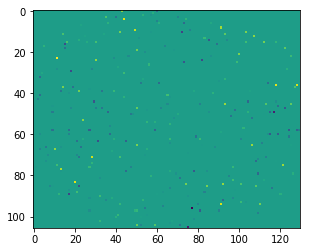

In [75]:
plt.imshow(output.sum(2))

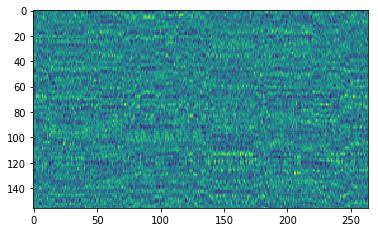

In [76]:
plt.imshow(cleaned_timeseries)

In [ ]:



class RestStateFMRIDataset()

In [1]:
!pip install torch

ModuleNotFoundError: No module named 'torch'